# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import pandas as pd
import numpy as np
import math
import json
import seaborn as sns;
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix

% matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [2]:
portfolio

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


In [3]:
portfolio_coded = portfolio.copy()

In [4]:
portfolio_coded['channel_email'] = np.NaN
portfolio_coded['channel_mobile'] = np.NaN
portfolio_coded['channel_social'] = np.NaN
portfolio_coded['channel_web'] = np.NaN
portfolio_coded['is_bogo'] = np.NaN
portfolio_coded['is_informational'] = np.NaN
portfolio_coded['is_discount'] = np.NaN

In [5]:
for i in range(0, portfolio_coded.shape[0]):
    portfolio_coded['channel_email'].iloc[i] = 1 if 'email' in portfolio_coded['channels'].iloc[i] else 0
    portfolio_coded['channel_mobile'].iloc[i] = 1 if 'mobile' in portfolio_coded['channels'].iloc[i] else 0
    portfolio_coded['channel_social'].iloc[i] = 1 if 'social' in portfolio_coded['channels'].iloc[i] else 0
    portfolio_coded['channel_web'].iloc[i] = 1 if 'web' in portfolio_coded['channels'].iloc[i] else 0
    portfolio_coded['is_bogo'].iloc[i] = 1 if portfolio_coded['offer_type'].iloc[i] == 'bogo' else 0
    portfolio_coded['is_informational'].iloc[i] = 1 if portfolio_coded['offer_type'].iloc[i]=='informational' else 0
    portfolio_coded['is_discount'].iloc[i] = 1 if portfolio_coded['offer_type'].iloc[i]=='discount' else 0

portfolio_coded = portfolio_coded.drop(['channels', 'offer_type'], axis=1)

/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [6]:
portfolio_coded

,difficulty,duration,id,reward,channel_email,channel_mobile,channel_social,channel_web,is_bogo,is_informational,is_discount
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,10,1.0,1.0,1.0,0.0,1.0,0.0,0.0
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,10,1.0,1.0,1.0,1.0,1.0,0.0,0.0
2,0,4,3f207df678b143eea3cee63160fa8bed,0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,1.0,1.0,0.0,1.0,1.0,0.0,0.0
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,1.0,0.0,0.0,1.0,0.0,0.0,1.0
5,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,3,1.0,1.0,1.0,1.0,0.0,0.0,1.0
6,10,10,fafdcd668e3743c1bb461111dcafc2a4,2,1.0,1.0,1.0,1.0,0.0,0.0,1.0
7,0,3,5a8bc65990b245e5a138643cd4eb9837,0,1.0,1.0,1.0,0.0,0.0,1.0,0.0
8,5,5,f19421c1d4aa40978ebb69ca19b0e20d,5,1.0,1.0,1.0,1.0,1.0,0.0,0.0
9,10,7,2906b810c7d4411798c6938adc9daaa5,2,1.0,1.0,0.0,1.0,0.0,0.0,1.0


In [7]:
portfolio_coded.to_csv('./portfolio_coded.csv', index=False)

In [8]:
portfolio_coded = pd.read_csv('./portfolio_coded.csv')

In [9]:
portfolio_coded.head()

,difficulty,duration,id,reward,channel_email,channel_mobile,channel_social,channel_web,is_bogo,is_informational,is_discount
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,10,1.0,1.0,1.0,0.0,1.0,0.0,0.0
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,10,1.0,1.0,1.0,1.0,1.0,0.0,0.0
2,0,4,3f207df678b143eea3cee63160fa8bed,0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,1.0,1.0,0.0,1.0,1.0,0.0,0.0
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,1.0,0.0,0.0,1.0,0.0,0.0,1.0


#### In next step, we start to investigate the profile dataset

In [10]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [11]:
profile.shape[0]

17000

In [12]:
profile.age.value_counts()

118    2175
58      408
53      372
51      363
54      359
59      359
57      353
52      351
55      350
56      342
63      338
60      333
49      321
62      318
67      317
64      311
61      309
48      288
50      284
66      284
65      280
68      259
70      252
69      242
47      232
45      231
71      230
42      227
43      215
46      212
       ... 
22      131
30      131
29      129
23      126
81      118
35      118
79      117
80      116
31      113
82      105
83      102
84       83
18       70
85       70
87       66
88       64
86       54
89       53
90       52
91       47
92       40
94       33
93       29
95       22
97       13
100      12
96        8
98        5
99        5
101       5
Name: age, Length: 85, dtype: int64

#### Check the NA value of profile, and the age 118 that is abnormal value, the rows of 118 and the NA values are all 2175

In [13]:
profile.gender.isna().sum()

2175

In [14]:
profile.income.isna().sum()

2175

In [15]:
# get the data that age is 118
profile_118 = profile[profile['age'] == 118]

In [16]:
profile_118.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN
6,118,20170925,None,8ec6ce2a7e7949b1bf142def7d0e0586,NaN
7,118,20171002,None,68617ca6246f4fbc85e91a2a49552598,NaN


In [17]:
profile_118.gender.value_counts()

Series([], Name: gender, dtype: int64)

In [18]:
profile_118.income.value_counts()

Series([], Name: income, dtype: int64)

So, these records do not have age, gender and income.

In [19]:
# We can delete all rows with the age of 118
profile_clean = profile.copy()
profile_clean.drop(profile_clean[profile_clean['age'] == 118].index, inplace=True)

In [20]:
profile_clean.gender.value_counts()

M    8484
F    6129
O     212
Name: gender, dtype: int64

In [21]:
# coded the profile_clean dataset
profile_clean['is_male'] = np.where(profile_clean['gender'] == 'M', 1, 0)

In [22]:
profile_clean.is_male.value_counts()

1    8484
0    6341
Name: is_male, dtype: int64

In [23]:
profile_clean= profile_clean.drop('gender', axis=1)
profile_clean.head(1)

,age,became_member_on,id,income,is_male
1,55,20170715,0610b486422d4921ae7d2bf64640c50b,112000.0,0


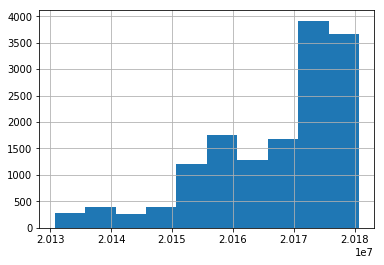

In [24]:
profile_clean.became_member_on.hist()

#### How many years of a people became a member is an important factor, we can get it based on the field of 'became_member_on'

In [25]:
# transfer the column of became_member_on to member_year
profile_clean['member_year'] = profile_clean['became_member_on'].map(lambda became_member_on:2020 - int(str(became_member_on)[:4]))

In [26]:
profile_clean['member_year'].value_counts()

3    5599
2    3669
4    3024
5    1597
6     662
7     274
Name: member_year, dtype: int64

In [ ]:
profile_clean['member_year'].hist()

In [59]:
profile_clean = profile_clean.drop('became_member_on', axis=1)

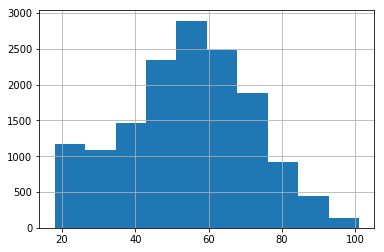

In [60]:
profile_clean.age.hist()

From the histgram of age above, the age distribution likes a normal distribution which mean value is around 50 year

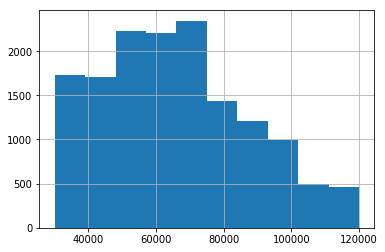

In [61]:
profile_clean.income.hist()

#### Next, we will categorize the age and income to groups

In [62]:
# Make age_stage for every 10 years
profile_clean['age_stage'] = profile_clean['age'].map(lambda age: int(age/10))

In [63]:
profile_clean = profile_clean.drop('age', axis=1)

In [64]:
# Make income_stage for every 10000
profile_clean['income_stage'] = profile_clean['income'].map(lambda income: int(income/10000))

In [65]:
profile_clean = profile_clean.drop('income', axis=1)

#### Next, we investigate the dataset of transcript

In [66]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [67]:
transcript.shape

(306534, 4)

In [68]:
transcript.event.value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

In [69]:
transcript_clean = transcript.copy()

From above analysis, we can transfer dataset of transcript to a new dataset based on following steps:
1. Abstract the information (offer_id and amount) from value field;
2. From the information of value, we generate three events: no response, viewed offer but not use, use offer

In [73]:
# Extract info
def get_amount_from_value(value):
    if('amount' in value.keys()):
        return value['amount']

transcript_clean['amount'] = transcript_clean['value'].map(get_amount_from_value)

In [74]:
# Extract offer id
def get_offer_id_from_value(value):
    if('offer id' in value.keys()):
        return value['offer id']
    if('offer_id' in value.keys()):
        return value['offer_id']

transcript_clean['offer_id'] = transcript_clean['value'].map(get_offer_id_from_value)

It is easy to check one person's events in record:

In [75]:
transcript_clean[transcript_clean['person']=='0009655768c64bdeb2e877511632db8f']

,event,person,time,value,amount,offer_id
55972,offer received,0009655768c64bdeb2e877511632db8f,168,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},NaN,5a8bc65990b245e5a138643cd4eb9837
77705,offer viewed,0009655768c64bdeb2e877511632db8f,192,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},NaN,5a8bc65990b245e5a138643cd4eb9837
89291,transaction,0009655768c64bdeb2e877511632db8f,228,{'amount': 22.16},22.16,None
113605,offer received,0009655768c64bdeb2e877511632db8f,336,{'offer id': '3f207df678b143eea3cee63160fa8bed'},NaN,3f207df678b143eea3cee63160fa8bed
139992,offer viewed,0009655768c64bdeb2e877511632db8f,372,{'offer id': '3f207df678b143eea3cee63160fa8bed'},NaN,3f207df678b143eea3cee63160fa8bed
153401,offer received,0009655768c64bdeb2e877511632db8f,408,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},NaN,f19421c1d4aa40978ebb69ca19b0e20d
168412,transaction,0009655768c64bdeb2e877511632db8f,414,{'amount': 8.57},8.57,None
168413,offer completed,0009655768c64bdeb2e877511632db8f,414,{'offer_id': 'f19421c1d4aa40978ebb69ca19b0e20d...,NaN,f19421c1d4aa40978ebb69ca19b0e20d
187554,offer viewed,0009655768c64bdeb2e877511632db8f,456,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},NaN,f19421c1d4aa40978ebb69ca19b0e20d
204340,offer received,0009655768c64bdeb2e877511632db8f,504,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},NaN,fafdcd668e3743c1bb461111dcafc2a4


In [76]:
# Calculate the transaction amount for each person
transaction_amount_person = transcript_clean.groupby('person')['amount'].sum()

In [77]:
# Merge the total transaction amount for each person to profile_clean dataframe
profile_clean = pd.merge(profile_clean, transaction_amount_person.to_frame(), left_on='id', right_on='person')

In [78]:
profile_clean.head(1)

,id,is_male,member_year,age_stage,income_stage,amount
0,0610b486422d4921ae7d2bf64640c50b,0,3,5,11,77.01


Here, we can analysis the situation of customers by using profile_clean dataframe

member_year
2    3669
3    5599
4    3024
5    1597
6     662
7     274
Name: id, dtype: int64


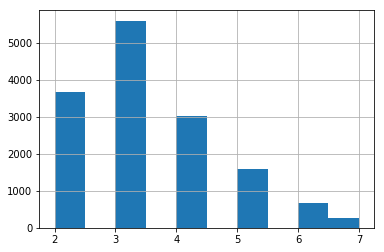

In [79]:
# Distribution of member years
print(profile_clean.groupby('member_year')['id'].count())
profile_clean.member_year.hist()

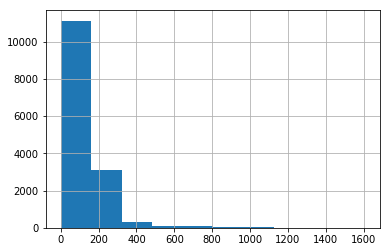

In [80]:
# Distribution of totol amount spent by customer:
profile_clean.amount.hist()

In [81]:
# We can classify the amount into different stages, 100 per stage:
profile_clean['amount_stage'] = profile_clean['amount'].map(lambda amount: int(amount/100))

In [82]:
transcript_event_count = pd.DataFrame({'count' : transcript_clean.groupby(['person','offer_id', 'event'])['event'].count()}).reset_index()

In [83]:
transcript_event_count.head()

,person,offer_id,event,count
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,offer completed,1
1,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,offer received,1
2,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,offer received,1
3,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,offer viewed,1
4,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,offer received,1


In [84]:
transcript_completed_count = transcript_event_count[transcript_event_count['event']=='offer completed']
transcript_completed_count = transcript_completed_count.drop('event', axis=1)
transcript_completed_count.columns = ['person', 'offer_id', 'offer_completed']

In [85]:
transcript_viewed_count = transcript_event_count[transcript_event_count['event']=='offer viewed']
transcript_viewed_count = transcript_viewed_count.drop('event', axis=1)
transcript_viewed_count.columns = ['person', 'offer_id', 'offer_viewed']
transcript_received_count = transcript_event_count[transcript_event_count['event']=='offer received']
transcript_received_count = transcript_received_count.drop('event', axis=1)
transcript_received_count.columns = ['person', 'offer_id', 'offer_received']

In [98]:
transcript_event_count = pd.merge(transcript_received_count, 
                                  transcript_viewed_count, 
                                  how='left', 
                                  left_on = ['person', 'offer_id'],
                                  right_on = ['person', 'offer_id']
                                 )

In [99]:
transcript_event_count = pd.merge(transcript_event_count, 
                                  transcript_completed_count, 
                                  how='left', 
                                  left_on = ['person', 'offer_id'],
                                  right_on = ['person', 'offer_id']
                                 )

In [100]:
transcript_event_count.fillna(0, inplace=True)

In [101]:
transcript_event_count.to_csv('./transcript_event_count.csv', index=False)

In [102]:
transcript_event_count = pd.read_csv('./transcript_event_count.csv')

In [103]:
transcript_event_count.head()

,person,offer_id,offer_received,offer_viewed,offer_completed
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,1,0.0,1.0
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,1,1.0,0.0
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,1,1.0,0.0
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,1,1.0,1.0
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,1,1.0,1.0


In [104]:
transcript_event_count_wide = pd.merge(
                                       transcript_event_count, 
                                       profile_clean, 
                                       left_on = ['person'],
                                       right_on = ['id']
                                      )

In [105]:
transcript_event_count_wide = transcript_event_count_wide.drop(['id', 'amount'], axis=1)

In [106]:
transcript_event_count_wide = pd.merge(
                                       transcript_event_count_wide, 
                                       portfolio_coded, 
                                       left_on = ['offer_id'],
                                       right_on = ['id']
                                      )

In [107]:
transcript_event_count_wide = pd.merge(
                                       transcript_event_count_wide, 
                                       portfolio[['id', 'offer_type']], 
                                       left_on = ['offer_id'],
                                       right_on = ['id']
                                      )

In [108]:
transcript_event_count_wide = transcript_event_count_wide.drop('id_y', axis=1)

#### Based on the table of 'transcript_event_count_wide', we can calculate many metrics from different dimensions, for example:

In [109]:
# calculate the usage of different types of offer
transcript_event_count_wide.groupby('offer_type')['offer_received', 'offer_viewed', 'offer_completed'].sum()

,offer_received,offer_viewed,offer_completed
offer_type,,,
bogo,26537,22039.0,15258.0
discount,26664,18461.0,17186.0
informational,13300,9360.0,0.0


#### From the table above, we can find the informational offer will not be used

In [110]:
# get the table for different ages:
transcript_event_count_wide.groupby(['offer_type', 'age_stage'])['offer_received', 'offer_viewed', 'offer_completed'].sum()

offer_received  offer_viewed  offer_completed
offer_type    age_stage                                               
bogo          1                     381         308.0            141.0
              2                    2450        2003.0           1059.0
              3                    2710        2220.0           1353.0
              4                    4184        3595.0           2324.0
              5                    6322        5222.0           3965.0
              6                    5349        4412.0           3210.0
              7                    3183        2617.0           1938.0
              8                    1457        1250.0            955.0
              9                     477         389.0            294.0
              10                     24          23.0             19.0
discount      1                     341         204.0            179.0
              2                    2547        1509.0           1327.0
              3                    2805        1819.0           1656.0
              4                    4057        2966.0           2535.0
              5                    6370        4482.0           4307.0
              6                    5431        3918.0           3704.0
              7                    3152        2203.0           2114.0
              8                    1488        1032.0           1048.0
              9                     438         305.0            290.0
              10                     35          23.0             26.0
informational 1                     199         140.0              0.0
              2                    1177         749.0              0.0
              3                    1378         937.0              0.0
              4                    2047        1550.0              0.0
              5                    3202        2304.0              0.0
              6                    2643        1842.0              0.0
              7                    1614        1126.0              0.0
              8                     793         551.0              0.0
              9                     232         149.0              0.0
              10                     15          12.0              0.0

In [111]:
# get the table for different member year:
transcript_event_count_wide.groupby(['offer_type', 'member_year'])['offer_received', 'offer_viewed', 'offer_completed'].sum()

offer_received  offer_viewed  offer_completed
offer_type    member_year                                               
bogo          2                      6494        5384.0           2392.0
              3                     10116        8360.0           5840.0
              4                      5367        4477.0           4263.0
              5                      2893        2417.0           2040.0
              6                      1166         974.0            496.0
              7                       501         427.0            227.0
discount      2                      6765        4587.0           2804.0
              3                      9918        6861.0           6279.0
              4                      5440        3897.0           4665.0
              5                      2855        1951.0           2279.0
              6                      1205         845.0            825.0
              7                       481         320.0            334.0
informational 2                      3248        2203.0              0.0
              3                      5091        3598.0              0.0
              4                      2713        1945.0              0.0
              5                      1402        1008.0              0.0
              6                       602         440.0              0.0
              7                       244         166.0              0.0

# Next, we try to establish model to predict customers' response

In [112]:
profile_clean.describe()

,is_male,member_year,age_stage,income_stage,amount,amount_stage
count,14825.000000,14825.000000,14825.000000,14825.000000,14825.000000,14825.000000
mean,0.572277,3.379831,4.990624,6.103946,117.028155,0.748061
std,0.494765,1.198245,1.763463,2.150045,129.965016,1.265061
min,0.000000,2.000000,1.000000,3.000000,0.000000,0.000000
25%,0.000000,3.000000,4.000000,4.000000,31.450000,0.000000
50%,1.000000,3.000000,5.000000,6.000000,87.040000,0.000000
75%,1.000000,4.000000,6.000000,8.000000,160.900000,1.000000
max,1.000000,7.000000,10.000000,12.000000,1608.690000,16.000000


In [113]:
profile_clean.head()

,id,is_male,member_year,age_stage,income_stage,amount,amount_stage
0,0610b486422d4921ae7d2bf64640c50b,0,3,5,11,77.01,0
1,78afa995795e4d85b5d9ceeca43f5fef,0,3,7,10,159.27,1
2,e2127556f4f64592b11af22de27a7932,1,2,6,7,57.73,0
3,389bc3fa690240e798340f5a15918d5c,1,2,6,5,36.43,0
4,2eeac8d8feae4a8cad5a6af0499a211d,1,3,5,5,15.62,0


In [114]:
profile_for_cluster = profile_clean.drop(['id', 'amount'], axis = 1)

In [116]:
scaler=MinMaxScaler()
# store them in this dataframe
profile_cluster_scaled=pd.DataFrame(scaler.fit_transform(profile_for_cluster.astype(float)))

# get same features and indices
profile_cluster_scaled.columns=profile_for_cluster.columns
profile_cluster_scaled.index=profile_for_cluster.index

In [117]:
profile_cluster_scaled.head()

,is_male,member_year,age_stage,income_stage,amount_stage
0,0.0,0.2,0.444444,0.888889,0.0000
1,0.0,0.2,0.666667,0.777778,0.0625
2,1.0,0.0,0.555556,0.444444,0.0000
3,1.0,0.0,0.555556,0.222222,0.0000
4,1.0,0.2,0.444444,0.222222,0.0000


In [118]:
corr_matrix = profile_cluster_scaled.corr().abs().round(2)

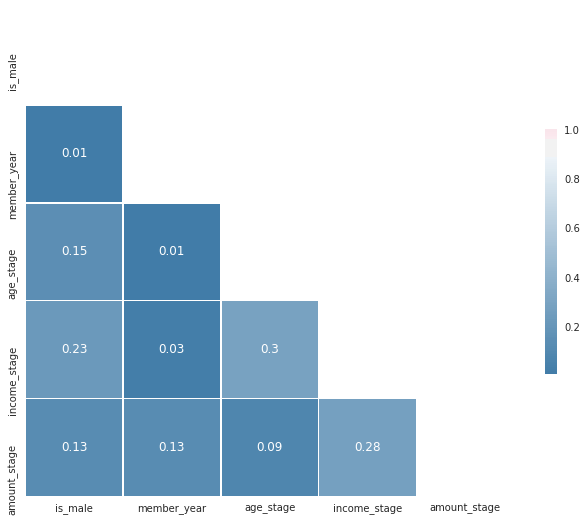

In [119]:
sns.set(style="white")
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(600, 0, sep=10, as_cmap=True)
mask = np.triu(np.ones_like(corr_matrix, dtype=np.bool))

sns.heatmap(corr_matrix, mask=mask, cmap=cmap, vmax=1, center=0.93, square=True, annot=True, linewidths=.5, cbar_kws={"shrink": .5})

#### From the correlation matrix, the features do not have high correlationship each other, we can apply Kmeans directly

In [120]:
kmeans = KMeans(n_clusters=3).fit(profile_cluster_scaled.iloc[:,1:4])

In [121]:
profile_cluster = kmeans.labels_   

In [122]:
profile_clean['cluster_type'] = profile_cluster

In [123]:
profile_clean.head()

,id,is_male,member_year,age_stage,income_stage,amount,amount_stage,cluster_type
0,0610b486422d4921ae7d2bf64640c50b,0,3,5,11,77.01,0,1
1,78afa995795e4d85b5d9ceeca43f5fef,0,3,7,10,159.27,1,1
2,e2127556f4f64592b11af22de27a7932,1,2,6,7,57.73,0,1
3,389bc3fa690240e798340f5a15918d5c,1,2,6,5,36.43,0,0
4,2eeac8d8feae4a8cad5a6af0499a211d,1,3,5,5,15.62,0,0


In [124]:
profile_clean.to_csv('./profile_clean.csv', index=False)

In [125]:
profile_clean = pd.read_csv('./profile_clean.csv')

In [126]:
profile_clean.groupby(['cluster_type']).mean()

,is_male,member_year,age_stage,income_stage,amount,amount_stage
cluster_type,,,,,,
0,0.663378,2.553527,4.352574,4.770926,73.132204,0.390561
1,0.415667,3.236211,6.038969,8.407274,162.647264,1.150879
2,0.633690,4.915508,4.625401,5.189572,127.363251,0.790374


#### From the table above, the type 0 has more female customers, their age and income are higher, and spend more money to buy from Starbucks;
#### The type 1 and type 2 customers are younger and have lower income. But type 1 customer has longer member age than other types, and this type of customers spend much more than type 2. 

In [127]:
transcript_event_count_wide = pd.merge(
                                       transcript_event_count_wide, 
                                       profile_clean[['id', 'cluster_type']], 
                                       left_on = ['person'],
                                       right_on = ['id']
                                      )

In [128]:
transcript_event_count_wide = transcript_event_count_wide.drop('id', axis=1)

In [129]:
transcript_event_count_wide.to_csv('./transcript_event_count_wide.csv', index=False)

In [130]:
transcript_event_count_wide = pd.read_csv('./transcript_event_count_wide.csv')

In [131]:
transcript_event_count_wide.head()

,person,offer_id,offer_received,offer_viewed,offer_completed,is_male,member_year,age_stage,income_stage,amount_stage,...,reward,channel_email,channel_mobile,channel_social,channel_web,is_bogo,is_informational,is_discount,offer_type,cluster_type
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,1,0.0,1.0,1,3,3,7,1,...,2,1.0,1.0,0.0,1.0,0.0,0.0,1.0,discount,0
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,1,1.0,0.0,1,3,3,7,1,...,0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,informational,0
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,1,1.0,0.0,1,3,3,7,1,...,0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,informational,0
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,1,1.0,1.0,1,3,3,7,1,...,5,1.0,1.0,1.0,1.0,1.0,0.0,0.0,bogo,0
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,1,1.0,1.0,1,3,3,7,1,...,2,1.0,1.0,1.0,1.0,0.0,0.0,1.0,discount,0


#### Then we can investigate the differences of response to offers among three types of customers:

In [132]:
transcript_event_count_wide.groupby(['offer_type', 'cluster_type']).sum()[['offer_received', 'offer_viewed', 'offer_completed']]

offer_received  offer_viewed  offer_completed
offer_type    cluster_type                                               
bogo          0                      10808        8939.0           4479.0
              1                       8967        7368.0           6453.0
              2                       6762        5732.0           4326.0
discount      0                      11056        7308.0           5189.0
              1                       8911        6509.0           6789.0
              2                       6697        4644.0           5208.0
informational 0                       5475        3756.0              0.0
              1                       4472        3135.0              0.0
              2                       3353        2469.0              0.0

#### From the table above, type 0 and 1 customers have high possibility level to response offer. Type 2 customers are not so resonsibile for offers. For the customers of Type 1, they have more higher rate of using discount offer than using bogo offer. 

## Next, we build the predict model for bogo offer

In [133]:
transcript_event_count_wide_bogo = transcript_event_count_wide[transcript_event_count_wide['offer_type'] == 'bogo']

In [135]:
transcript_event_count_wide_bogo = transcript_event_count_wide_bogo.drop(['is_bogo', 'is_informational', 'is_discount'], axis=1)

In [136]:
transcript_event_count_wide_bogo.head()

,person,offer_id,offer_received,offer_viewed,offer_completed,is_male,member_year,age_stage,income_stage,amount_stage,difficulty,duration,id_x,reward,channel_email,channel_mobile,channel_social,channel_web,offer_type,cluster_type
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,1,1.0,1.0,1,3,3,7,1,5,5,f19421c1d4aa40978ebb69ca19b0e20d,5,1.0,1.0,1.0,1.0,bogo,0
10,005500a7188546ff8a767329a2f7c76a,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,0.0,1.0,1,3,5,4,0,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,1.0,1.0,0.0,1.0,bogo,0
11,005500a7188546ff8a767329a2f7c76a,ae264e3637204a6fb9bb56bc8210ddfd,3,3.0,0.0,1,3,5,4,0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,10,1.0,1.0,1.0,0.0,bogo,0
15,00715b6e55c3431cb56ff7307eb19675,4d5c57ea9a6940dd891ad53e9dbe8da0,1,0.0,1.0,0,3,5,11,3,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,10,1.0,1.0,1.0,1.0,bogo,1
16,00715b6e55c3431cb56ff7307eb19675,ae264e3637204a6fb9bb56bc8210ddfd,1,1.0,1.0,0,3,5,11,3,10,7,ae264e3637204a6fb9bb56bc8210ddfd,10,1.0,1.0,1.0,0.0,bogo,1


In [137]:
transcript_event_count_wide_bogo['completed_rate'] = round(transcript_event_count_wide_bogo['offer_completed']/transcript_event_count_wide_bogo['offer_received'], 2)

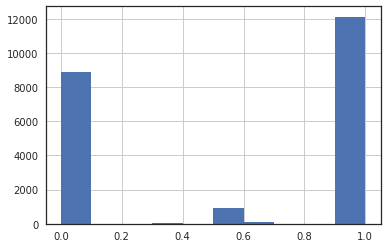

In [138]:
transcript_event_count_wide_bogo['completed_rate'].hist()

In [139]:
transcript_event_count_wide_bogo['viewed_rate'] = round(transcript_event_count_wide_bogo['offer_viewed']/transcript_event_count_wide_bogo['offer_received'], 2)

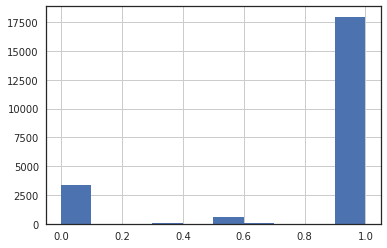

In [140]:
transcript_event_count_wide_bogo['viewed_rate'].hist()

#### To simply the problem, if the rate is higher than 0.5, it is 1, if not, it is 0

In [141]:
cols_should_drop = ['person', 'offer_id', 'offer_received', 'offer_viewed', 'offer_completed', 'id_x', 'offer_type', 'cluster_type']
bogo_predict_data = transcript_event_count_wide_bogo.drop(cols_should_drop, axis=1)

In [142]:
bogo_predict_data.head()

,is_male,member_year,age_stage,income_stage,amount_stage,difficulty,duration,reward,channel_email,channel_mobile,channel_social,channel_web,completed_rate,viewed_rate
3,1,3,3,7,1,5,5,5,1.0,1.0,1.0,1.0,1.0,1.0
10,1,3,5,4,0,5,7,5,1.0,1.0,0.0,1.0,1.0,0.0
11,1,3,5,4,0,10,7,10,1.0,1.0,1.0,0.0,0.0,1.0
15,0,3,5,11,3,10,5,10,1.0,1.0,1.0,1.0,1.0,0.0
16,0,3,5,11,3,10,7,10,1.0,1.0,1.0,0.0,1.0,1.0


In [145]:
bogo_predict_data['is_completed'] = bogo_predict_data['completed_rate'].map(lambda x: 1 if x>0.5 else 0)

In [146]:
y = bogo_predict_data['is_completed']
X = bogo_predict_data.drop(['completed_rate', 'viewed_rate', 'is_completed'], axis=1)

In [147]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.20, random_state=42)

In [148]:
param_grid={'max_features': ['auto', 'sqrt'],
                'max_depth' : [10,15],
                'n_estimators': [10,20,25,30],
                'min_samples_split': [10, 20],
                'min_samples_leaf': [10,15],
                }
grid_search_bogo = GridSearchCV(RandomForestClassifier(random_state=2), param_grid)
grid_search_bogo.fit(X_train, y_train)
grid_search_bogo.best_params_

{'max_depth': 10,
 'max_features': 'auto',
 'min_samples_leaf': 15,
 'min_samples_split': 10,
 'n_estimators': 20}

In [149]:
grid_search_bogo.best_score_

0.78457702986004874

In [150]:
grid_search_bogo.score(X_test, y_test)

0.77498300475866755

In [151]:
y_pred = grid_search_bogo.predict(X_test)

In [152]:
confusion_matrix(y_test, y_pred)

array([[1589,  419],
       [ 574, 1831]])

#### From the confusion matrix, the model's recall is 81%

## Next, we build the model for discount offer

In [153]:
transcript_event_count_wide_discount = transcript_event_count_wide[transcript_event_count_wide['offer_type'] == 'discount']

In [154]:
transcript_event_count_wide_discount = transcript_event_count_wide_discount.drop(['is_bogo', 'is_informational', 'is_discount'], axis=1)

In [155]:
transcript_event_count_wide_discount['completed_rate'] = round(transcript_event_count_wide_discount['offer_completed']/transcript_event_count_wide_discount['offer_received'], 2)

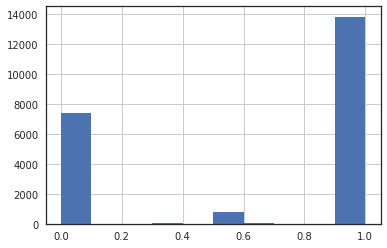

In [156]:
transcript_event_count_wide_discount['completed_rate'].hist()

In [157]:
discount_predict_data = transcript_event_count_wide_discount.drop(cols_should_drop, axis=1)

In [159]:
discount_predict_data['is_completed'] = discount_predict_data['completed_rate'].map(lambda x: 1 if x>0.5 else 0)
# discount_predict_data = discount_predict_data.drop(['completed_rate'], axis = 1)

In [160]:
y = discount_predict_data['is_completed']
X = discount_predict_data.drop(['is_completed', 'completed_rate'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.20, random_state=42)

In [161]:
param_grid={'max_features': ['auto', 'sqrt'],
                'max_depth' : [10,15],
                'n_estimators': [10,20,25,30],
                'min_samples_split': [10, 20],
                'min_samples_leaf': [10,15],
                }
grid_search_discount = GridSearchCV(RandomForestClassifier(random_state=2), param_grid)
grid_search_discount.fit(X_train, y_train)
grid_search_discount.best_params_

{'max_depth': 10,
 'max_features': 'auto',
 'min_samples_leaf': 15,
 'min_samples_split': 10,
 'n_estimators': 25}

In [162]:
grid_search_discount.best_score_

0.78084204577564287

In [163]:
grid_search_discount.score(X_test, y_test)

0.79023508137432186

In [164]:
y_pred = grid_search_discount.predict(X_test)

In [165]:
confusion_matrix(y_test, y_pred)

array([[1312,  334],
       [ 594, 2184]])

#### From the confusion matrix, the model's recall is 86.7%

## Next, we build the model for informational offer

In [166]:
transcript_event_count_wide_informational = transcript_event_count_wide[transcript_event_count_wide['offer_type'] == 'informational']

In [167]:
transcript_event_count_wide_informational = transcript_event_count_wide_informational.drop(['is_bogo', 'is_informational', 'is_discount'], axis=1)

Because informational offer just need to be viewed, so we just need to calculate viewed rate

In [168]:
transcript_event_count_wide_informational['viewed_rate'] = round(transcript_event_count_wide_informational['offer_viewed']/transcript_event_count_wide_informational['offer_received'], 2)

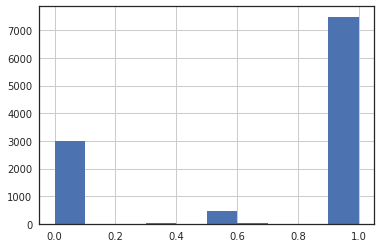

In [169]:
transcript_event_count_wide_informational['viewed_rate'].hist()

In [170]:
informational_predict_data = transcript_event_count_wide_informational.drop(cols_should_drop, axis=1)

In [171]:
informational_predict_data['is_viewed'] = informational_predict_data['viewed_rate'].map(lambda x: 1 if x>0.5 else 0)
# informational_predict_data = informational_predict_data.drop(['viewed_rate'], axis = 1)

In [172]:
y = informational_predict_data['is_viewed']
X = informational_predict_data.drop(['is_viewed', 'viewed_rate'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.20, random_state=42)

In [173]:
param_grid={'max_features': ['auto', 'sqrt'],
                'max_depth' : [10,15],
                'n_estimators': [10,20,25,30],
                'min_samples_split': [10, 20],
                'min_samples_leaf': [10,15],
                }
grid_search_informational = GridSearchCV(RandomForestClassifier(random_state=2), param_grid)
grid_search_informational.fit(X_train, y_train)
grid_search_informational.best_params_

{'max_depth': 15,
 'max_features': 'auto',
 'min_samples_leaf': 15,
 'min_samples_split': 10,
 'n_estimators': 30}

In [174]:
grid_search_informational.best_score_

0.76200181159420288

In [175]:
grid_search_informational.score(X_test, y_test)

0.77184246265278411

In [176]:
y_pred = grid_search_informational.predict(X_test)

In [177]:
confusion_matrix(y_test, y_pred)

array([[ 363,  325],
       [ 179, 1342]])

#### From the confusion matrix, the model's recall is 80.5%

In [178]:
bogo_predict_data.to_csv('./bogo_predict_data.csv', index=False)
discount_predict_data.to_csv('./discount_predict_data.csv', index=False)
informational_predict_data.to_csv('./informational_predict_data.csv', index=False)

In [2]:
bogo_predict_data = pd.read_csv('./bogo_predict_data.csv')
discount_predict_data = pd.read_csv('./discount_predict_data.csv')
informational_predict_data = pd.read_csv('./informational_predict_data.csv')

## Next, we will try other classifier model: Logistic Regression

#### LR model for bogo offers 

In [4]:
y = bogo_predict_data['is_completed']
X = bogo_predict_data.drop(['completed_rate', 'viewed_rate', 'is_completed'], axis=1)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.20, random_state=42)

In [8]:
params = {
            'penalty' : ['l1', 'l2'],
            'C' : np.logspace(-4, 4, 20),
            'solver' : ['liblinear'],
         }

grid_search_bogo = GridSearchCV(LogisticRegression(),params)
grid_search_bogo.fit(X_train, y_train)
grid_search_bogo.best_params_

{'C': 0.088586679041008226, 'penalty': 'l1', 'solver': 'liblinear'}

In [9]:
grid_search_bogo.best_score_

0.78066745991274289

In [10]:
grid_search_bogo.score(X_test, y_test)

0.77226376614547931

In [11]:
y_pred = grid_search_bogo.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[1650,  358],
       [ 647, 1758]])

#### From the confusion matrix, the model's recall is 83.1%

#### LR model for discount offers

In [12]:
y = discount_predict_data['is_completed']
X = discount_predict_data.drop(['completed_rate', 'is_completed'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.20, random_state=42)

In [13]:
params = {
            'penalty' : ['l1', 'l2'],
            'C' : np.logspace(-4, 4, 20),
            'solver' : ['liblinear'],
         }

grid_search_discount = GridSearchCV(LogisticRegression(),params)
grid_search_discount.fit(X_train, y_train)
grid_search_discount.best_params_

{'C': 0.012742749857031334, 'penalty': 'l1', 'solver': 'liblinear'}

In [14]:
grid_search_discount.best_score_

0.77536027126306861

In [16]:
grid_search_discount.score(X_test, y_test)

0.78842676311030746

In [17]:
y_pred = grid_search_discount.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[1163,  483],
       [ 453, 2325]])

#### From the confusion matrix, the model's recall is 82.8%

#### LR model for informational offers

In [18]:
y = informational_predict_data['is_viewed']
X = informational_predict_data.drop(['viewed_rate', 'is_viewed'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.20, random_state=42)

In [19]:
params = {
            'penalty' : ['l1', 'l2'],
            'C' : np.logspace(-4, 4, 20),
            'solver' : ['liblinear'],
         }

grid_search_informational = GridSearchCV(LogisticRegression(),params)
grid_search_informational.fit(X_train, y_train)
grid_search_informational.best_params_

{'C': 0.033598182862837812, 'penalty': 'l1', 'solver': 'liblinear'}

In [21]:
grid_search_informational.best_score_

0.71456068840579712

In [22]:
grid_search_informational.score(X_test, y_test)

0.71706654594839292

In [23]:
y_pred = grid_search_informational.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[ 349,  339],
       [ 286, 1235]])

#### From the confusion matrix, the model's recall is 78.5% 

## Next, we will try the SVM for modelling:  

#### SVM model for bogo offers: 

In [3]:
y = bogo_predict_data['is_completed']
X = bogo_predict_data.drop(['completed_rate', 'viewed_rate', 'is_completed'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.20, random_state=42)

params = {'C': [0.1,1], 'gamma': [0.1,0.01,0.001],'kernel': ['rbf', 'sigmoid']}
grid_search_bogo = GridSearchCV(SVC(),params, refit=True,verbose=2)
grid_search_bogo.fit(X_train, y_train)
grid_search_bogo.best_params_

In [5]:
grid_search_bogo.best_score_

0.78100742251685651

In [6]:
grid_search_bogo.score(X_test, y_test)

0.77543621119419892

In [7]:
y_pred = grid_search_bogo.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[1652,  356],
       [ 635, 1770]])

#### From the confusion matrix, the model's recall is 83.3%

#### SVM model for discount offers:

In [9]:
y = discount_predict_data['is_completed']
X = discount_predict_data.drop(['completed_rate', 'is_completed'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.20, random_state=42)

In [10]:
params = {'C': [0.1,1], 'gamma': [0.1,0.01],'kernel': ['rbf', 'sigmoid']}
grid_search_discount = GridSearchCV(SVC(),params,verbose=2)
grid_search_discount.fit(X_train, y_train)
grid_search_discount.best_params_

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ..................... C=0.1, gamma=0.1, kernel=rbf, total=   7.8s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.9s remaining:    0.0s


[CV] ..................... C=0.1, gamma=0.1, kernel=rbf, total=   7.7s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ..................... C=0.1, gamma=0.1, kernel=rbf, total=   7.8s
[CV] C=0.1, gamma=0.1, kernel=sigmoid ................................
[CV] ................. C=0.1, gamma=0.1, kernel=sigmoid, total=   5.5s
[CV] C=0.1, gamma=0.1, kernel=sigmoid ................................
[CV] ................. C=0.1, gamma=0.1, kernel=sigmoid, total=   5.5s
[CV] C=0.1, gamma=0.1, kernel=sigmoid ................................
[CV] ................. C=0.1, gamma=0.1, kernel=sigmoid, total=   5.5s
[CV] C=0.1, gamma=0.01, kernel=rbf ...................................
[CV] .................... C=0.1, gamma=0.01, kernel=rbf, total=   8.0s
[CV] C=0.1, gamma=0.01, kernel=rbf ...................................
[CV] .................... C=0.1, gamma=0.01, kernel=rbf, total=   7.7s
[CV] C=0.1, gamma=0.01, kernel=rbf ...................................
[CV] .

[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:  4.2min finished


{'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}

In [11]:
grid_search_discount.best_score_

0.78519355750211928

In [12]:
grid_search_discount.score(X_test, y_test)

0.79204339963833637

In [13]:
y_pred = grid_search_discount.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[1424,  222],
       [ 698, 2080]])

#### From the confusion matrix, the model's recall is 90.4%

#### SVM model for informational offers:

In [14]:
y = informational_predict_data['is_viewed']
X = informational_predict_data.drop(['viewed_rate', 'is_viewed'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.20, random_state=42)

In [15]:
params = {'C': [0.1,1], 'gamma': [0.1,0.01],'kernel': ['rbf', 'sigmoid']}
grid_search_informational = GridSearchCV(SVC(),params,verbose=2)
grid_search_informational.fit(X_train, y_train)
grid_search_informational.best_params_

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ..................... C=0.1, gamma=0.1, kernel=rbf, total=   2.1s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.9s remaining:    0.0s


[CV] ..................... C=0.1, gamma=0.1, kernel=rbf, total=   2.1s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ..................... C=0.1, gamma=0.1, kernel=rbf, total=   2.1s
[CV] C=0.1, gamma=0.1, kernel=sigmoid ................................
[CV] ................. C=0.1, gamma=0.1, kernel=sigmoid, total=   2.2s
[CV] C=0.1, gamma=0.1, kernel=sigmoid ................................
[CV] ................. C=0.1, gamma=0.1, kernel=sigmoid, total=   2.2s
[CV] C=0.1, gamma=0.1, kernel=sigmoid ................................
[CV] ................. C=0.1, gamma=0.1, kernel=sigmoid, total=   2.2s
[CV] C=0.1, gamma=0.01, kernel=rbf ...................................
[CV] .................... C=0.1, gamma=0.01, kernel=rbf, total=   2.2s
[CV] C=0.1, gamma=0.01, kernel=rbf ...................................
[CV] .................... C=0.1, gamma=0.01, kernel=rbf, total=   2.2s
[CV] C=0.1, gamma=0.01, kernel=rbf ...................................
[CV] .

[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:  1.2min finished


{'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}

In [16]:
grid_search_informational.best_score_

0.75566123188405798

In [17]:
grid_search_informational.score(X_test, y_test)

0.76867360796740603

In [18]:
y_pred = grid_search_informational.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[ 340,  348],
       [ 163, 1358]])

#### From the confusion matrix, the model's recall is 79.6%

## The models we established above that simplify the customers' response to 0 and 1. If we consider the probability of response, for example, if one customer get an offer two times, but just use one time, the rate is 0.5. To predict the rate is a problem of regression. We can use Random Forest Regressor to build the models.

## First, build the regression model for bogo offer

In [184]:
y = bogo_predict_data['completed_rate']
X = bogo_predict_data.drop(['completed_rate', 'viewed_rate', 'is_completed'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.20, random_state=42)

In [194]:
param_grid={'max_features': ['auto', 'sqrt'],
                'max_depth' : [10,15,25],
                'n_estimators': [10,20,25,30,45],
                'min_samples_split': [10,20],
                'min_samples_leaf': [10,15],
                'bootstrap':[True, False]
                }
grid_search_bogo = GridSearchCV(RandomForestRegressor(random_state=2), param_grid)
grid_search_bogo.fit(X_train, y_train)
grid_search_bogo.best_params_

{'bootstrap': True,
 'max_depth': 10,
 'max_features': 'sqrt',
 'min_samples_leaf': 15,
 'min_samples_split': 10,
 'n_estimators': 45}

In [195]:
pred_y = grid_search_bogo.predict(X_test)

In [196]:
errors = abs(pred_y - y_test)
print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))

Average Error: 0.2993 degrees.
Accuracy = -inf%.


(array([  812.,  1240.,   560.,   483.,   373.,   283.,   213.,   199.,
          151.,    99.]),
 array([  8.03612586e-04,   9.69347094e-02,   1.93065806e-01,
          2.89196903e-01,   3.85328000e-01,   4.81459097e-01,
          5.77590193e-01,   6.73721290e-01,   7.69852387e-01,
          8.65983484e-01,   9.62114580e-01]),
 <a list of 10 Patch objects>)

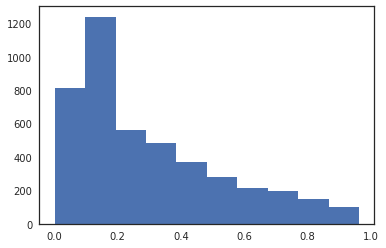

In [199]:
plt.hist(errors)

## Next, build the regression model for discount offer

In [203]:
y = discount_predict_data['completed_rate']
X = discount_predict_data.drop(['completed_rate', 'is_completed'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.20, random_state=42)

In [204]:
param_grid={'max_features': ['auto', 'sqrt'],
                'max_depth' : [10,15,25],
                'n_estimators': [40,50,60,70,80],
                'min_samples_split': [10,20],
                'min_samples_leaf': [10,15,20],
                'bootstrap':[True, False]
                }
grid_search_discount = GridSearchCV(RandomForestRegressor(random_state=2), param_grid)
grid_search_discount.fit(X_train, y_train)
grid_search_discount.best_params_

{'bootstrap': True,
 'max_depth': 10,
 'max_features': 'sqrt',
 'min_samples_leaf': 20,
 'min_samples_split': 10,
 'n_estimators': 80}

In [205]:
pred_y = grid_search_discount.predict(X_test)
errors = abs(pred_y - y_test)
print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))

Average Error: 0.2780 degrees.


(array([ 1196.,   936.,   602.,   330.,   483.,   449.,   150.,   123.,
          119.,    36.]),
 array([  1.28509114e-04,   9.93360517e-02,   1.98543594e-01,
          2.97751137e-01,   3.96958679e-01,   4.96166222e-01,
          5.95373764e-01,   6.94581307e-01,   7.93788849e-01,
          8.92996392e-01,   9.92203934e-01]),
 <a list of 10 Patch objects>)

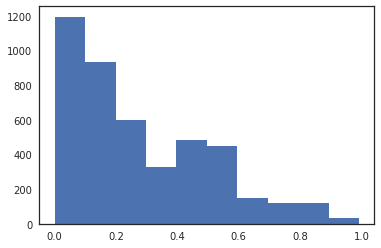

In [206]:
plt.hist(errors)

## Next, build the regression model for informational offer

In [207]:
y = informational_predict_data['viewed_rate']
X = informational_predict_data.drop(['viewed_rate', 'is_viewed'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.20, random_state=42)

In [208]:
param_grid={'max_features': ['auto', 'sqrt'],
                'max_depth' : [10,15,25],
                'n_estimators': [40,50,60],
                'min_samples_split': [10,20],
                'min_samples_leaf': [10,15,20],
                'bootstrap':[True, False]
                }
grid_search_informational = GridSearchCV(RandomForestRegressor(random_state=2), param_grid)
grid_search_informational.fit(X_train, y_train)
grid_search_informational.best_params_

{'bootstrap': True,
 'max_depth': 15,
 'max_features': 'sqrt',
 'min_samples_leaf': 20,
 'min_samples_split': 10,
 'n_estimators': 40}

In [209]:
pred_y = grid_search_informational.predict(X_test)
errors = abs(pred_y - y_test)
print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))

Average Error: 0.3003 degrees.


(array([ 645.,  229.,  381.,  260.,  236.,  192.,  101.,   85.,   45.,   35.]),
 array([ 0.00115085,  0.10028047,  0.19941009,  0.29853971,  0.39766933,
         0.49679895,  0.59592858,  0.6950582 ,  0.79418782,  0.89331744,
         0.99244706]),
 <a list of 10 Patch objects>)

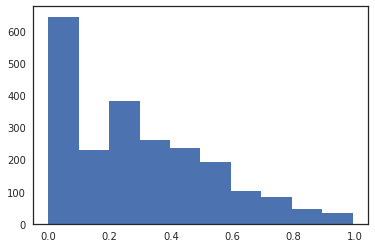

In [210]:
plt.hist(errors)

### From the results of Random Forest Regressor models, we can find the regression model is not good for this problem. Therefore, the best way of this project is transfering to classifier problem and using classifier model to predict. 